In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pymc_marketing.hsgp_kwargs import HSGPKwargs
from pymc_marketing.mmm.delayed_saturated_mmm import (
    MMM,
    GeometricAdstock,
    LogisticSaturation,
)
from pymc_marketing.prior import Prior

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed: int = sum(map(ord, "mmm_roas"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
raw_df = pd.read_csv("../../../../data/mmm_roas_data.csv", parse_dates=["date"])

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  131 non-null    datetime64[ns]
 1   dayofyear             131 non-null    int64         
 2   quarter               131 non-null    object        
 3   trend                 131 non-null    float64       
 4   cs                    131 non-null    float64       
 5   cc                    131 non-null    float64       
 6   seasonality           131 non-null    float64       
 7   z                     131 non-null    float64       
 8   x1                    131 non-null    float64       
 9   x2                    131 non-null    float64       
 10  epsilon               131 non-null    float64       
 11  x1_adstock            131 non-null    float64       
 12  x2_adstock            131 non-null    float64       
 13  x1_adstock_saturated

In [4]:
model_df = raw_df.copy().filter(["date", "x1", "x2", "y"])

/Users/juanitorduz/Documents/envs/pymc-marketing-dev/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


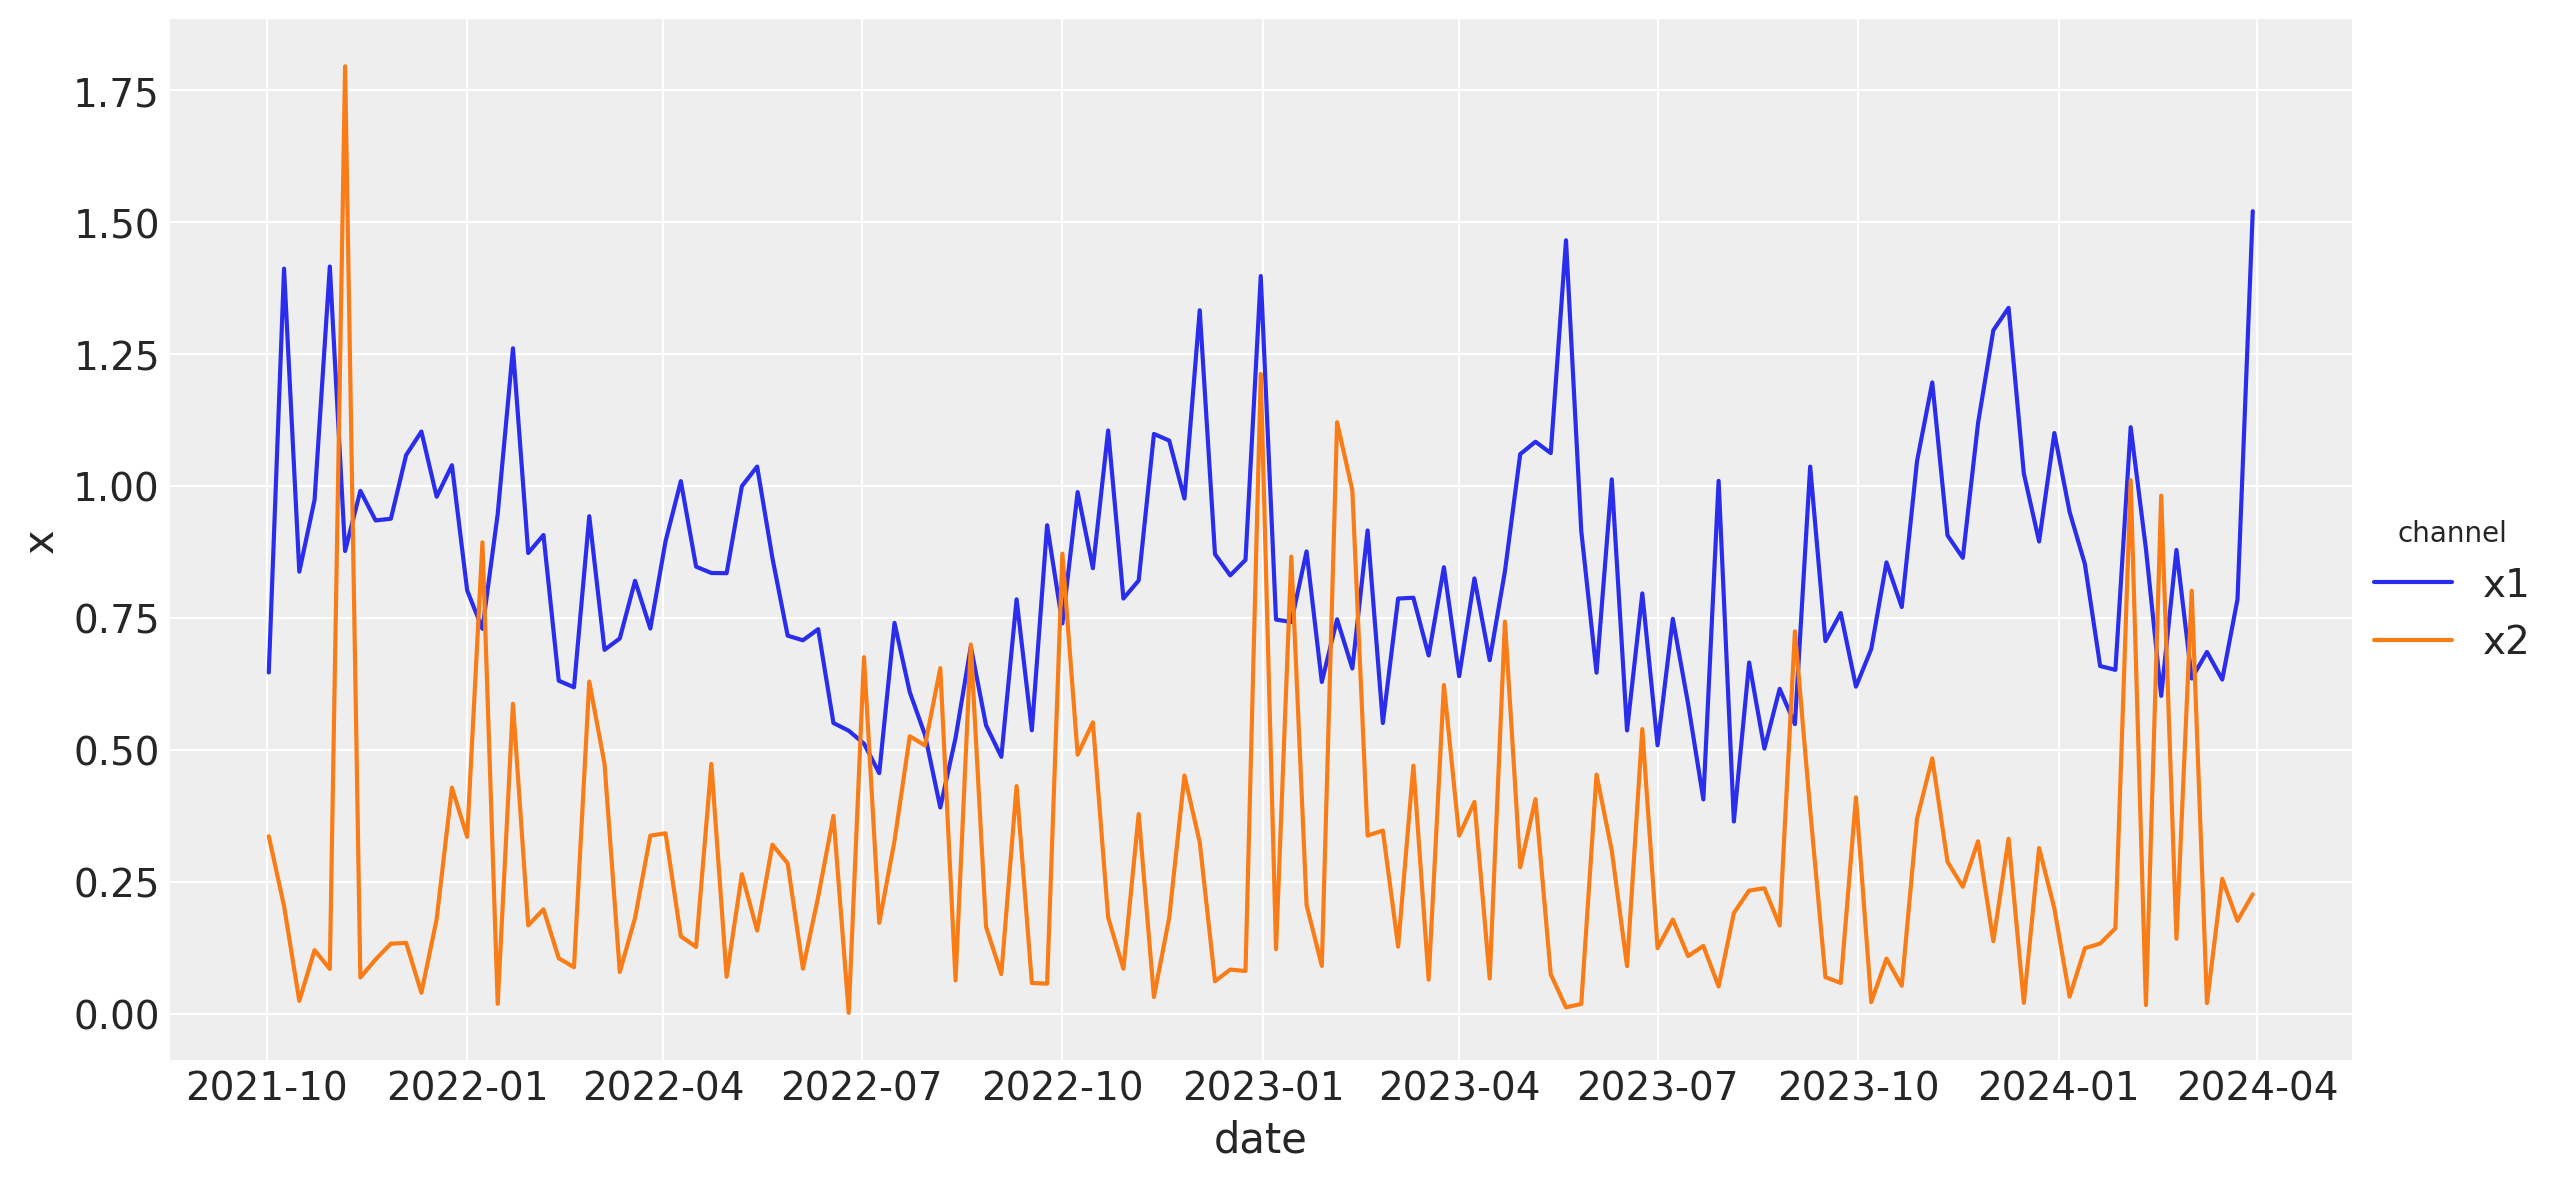

In [5]:
g = model_df.melt(
    id_vars=["date"], value_vars=["x1", "x2"], var_name="channel", value_name="x"
).pipe(
    (sns.relplot, "data"),
    kind="line",
    x="date",
    y="x",
    hue="channel",
    height=6,
    aspect=2,
);

In [6]:
cost_share = model_df[["x1", "x2"]].sum() / model_df[["x1", "x2"]].sum().sum()

In [7]:
model_config = {
    "intercept": Prior("Normal", mu=200, sigma=20),
    "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
    "gamma_fourier": Prior("Normal", mu=0, sigma=2, dims="fourier_mode"),
    "intercept_tvp_config": HSGPKwargs(
        m=50, L=None, eta_lam=1.0, ls_mu=5.0, ls_sigma=10.0, cov_func=None
    ),
    "adstock_alpha": Prior("Beta", alpha=2, beta=3, dims="channel"),
    "saturation_lam": Prior("Gamma", alpha=2, beta=2, dims="channel"),
    "saturation_beta": Prior("HalfNormal", sigma=cost_share.to_numpy(), dims="channel"),
}

In [8]:
%%time

mmm = MMM(
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
    date_column="date",
    channel_columns=["x1", "x2"],
    time_varying_intercept=True,
    time_varying_media=False,
    yearly_seasonality=5,
    model_config=model_config,
)

y = model_df["y"]
X = model_df.drop(columns=["y"])

fit_kwargs = {"chains": 4, "nuts_sampler": "numpyro", "random_seed": rng}

mmm.fit(X, y, **fit_kwargs)
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True, random_seed=rng)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [y]


Output()

CPU times: user 28.1 s, sys: 5.14 s, total: 33.2 s
Wall time: 15.2 s


<xarray.Dataset> Size: 4MB
Dimensions:  (date: 131, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2021-10-02 2021-10-09 ... 2024-03-30
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 4MB 209.6 203.9 189.8 ... 523.3 529.4 533.2
Attributes:
    created_at:                 2024-08-06T20:05:44.230818+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.15.1

In [9]:
# Number of diverging samples
mmm.idata["sample_stats"]["diverging"].sum().item()

0

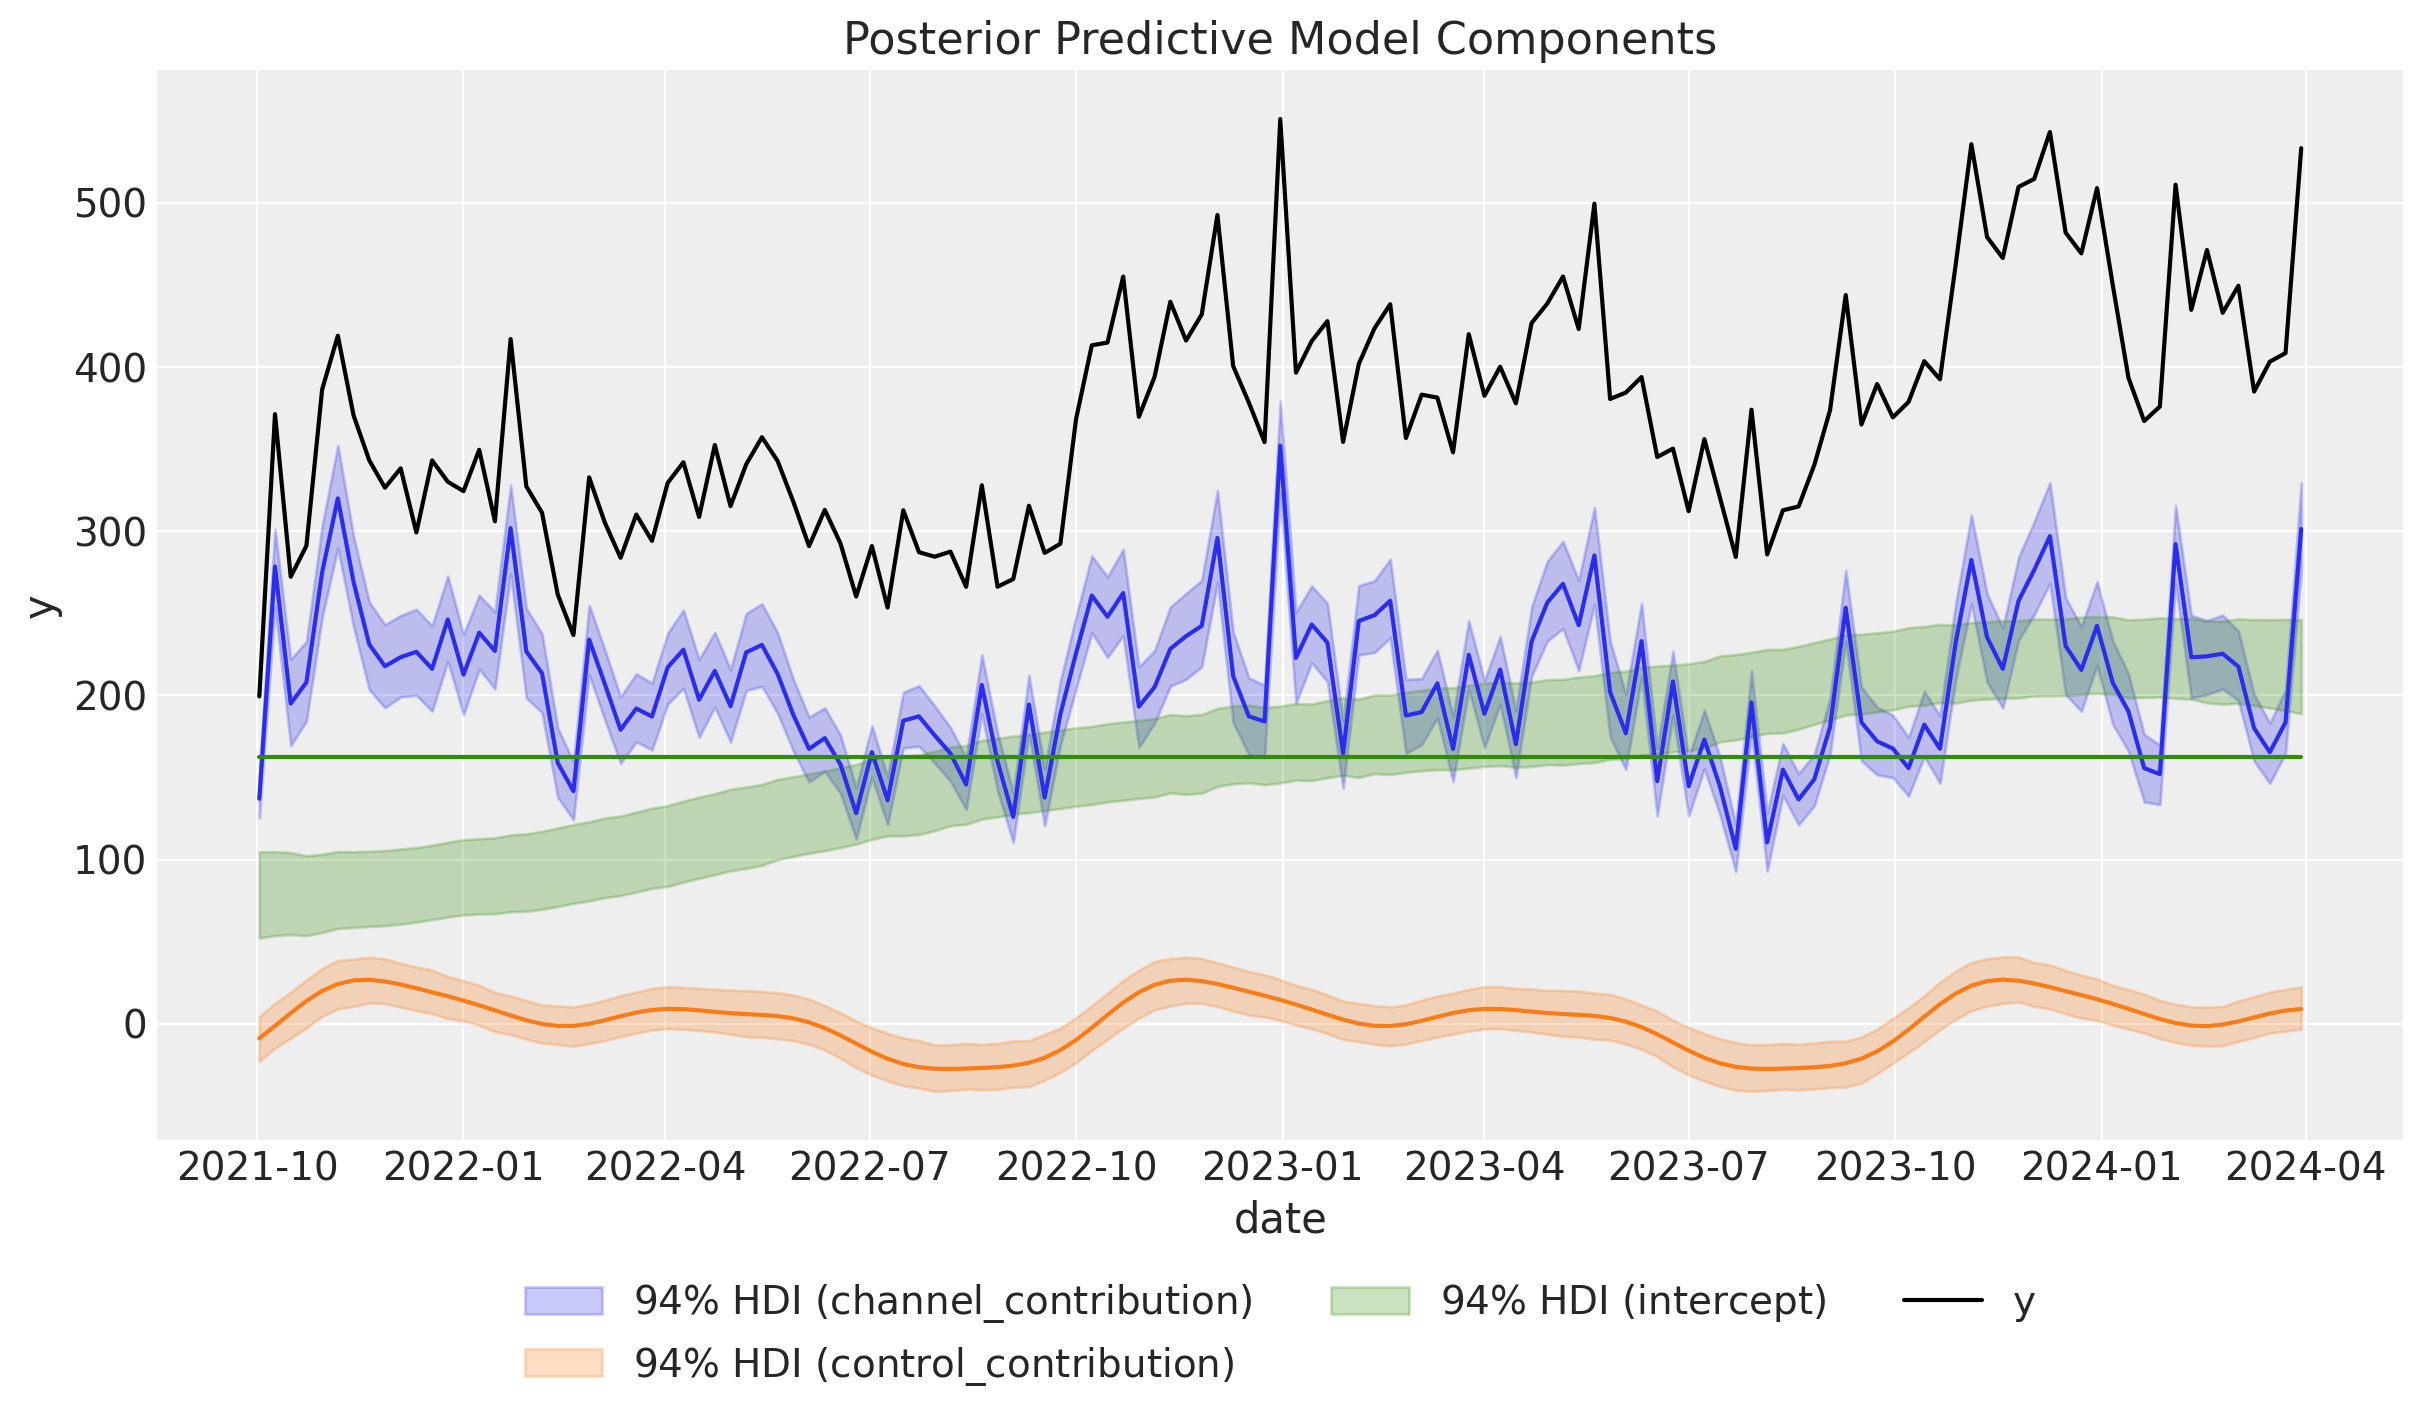

In [10]:
mmm.plot_components_contributions(original_scale=True);

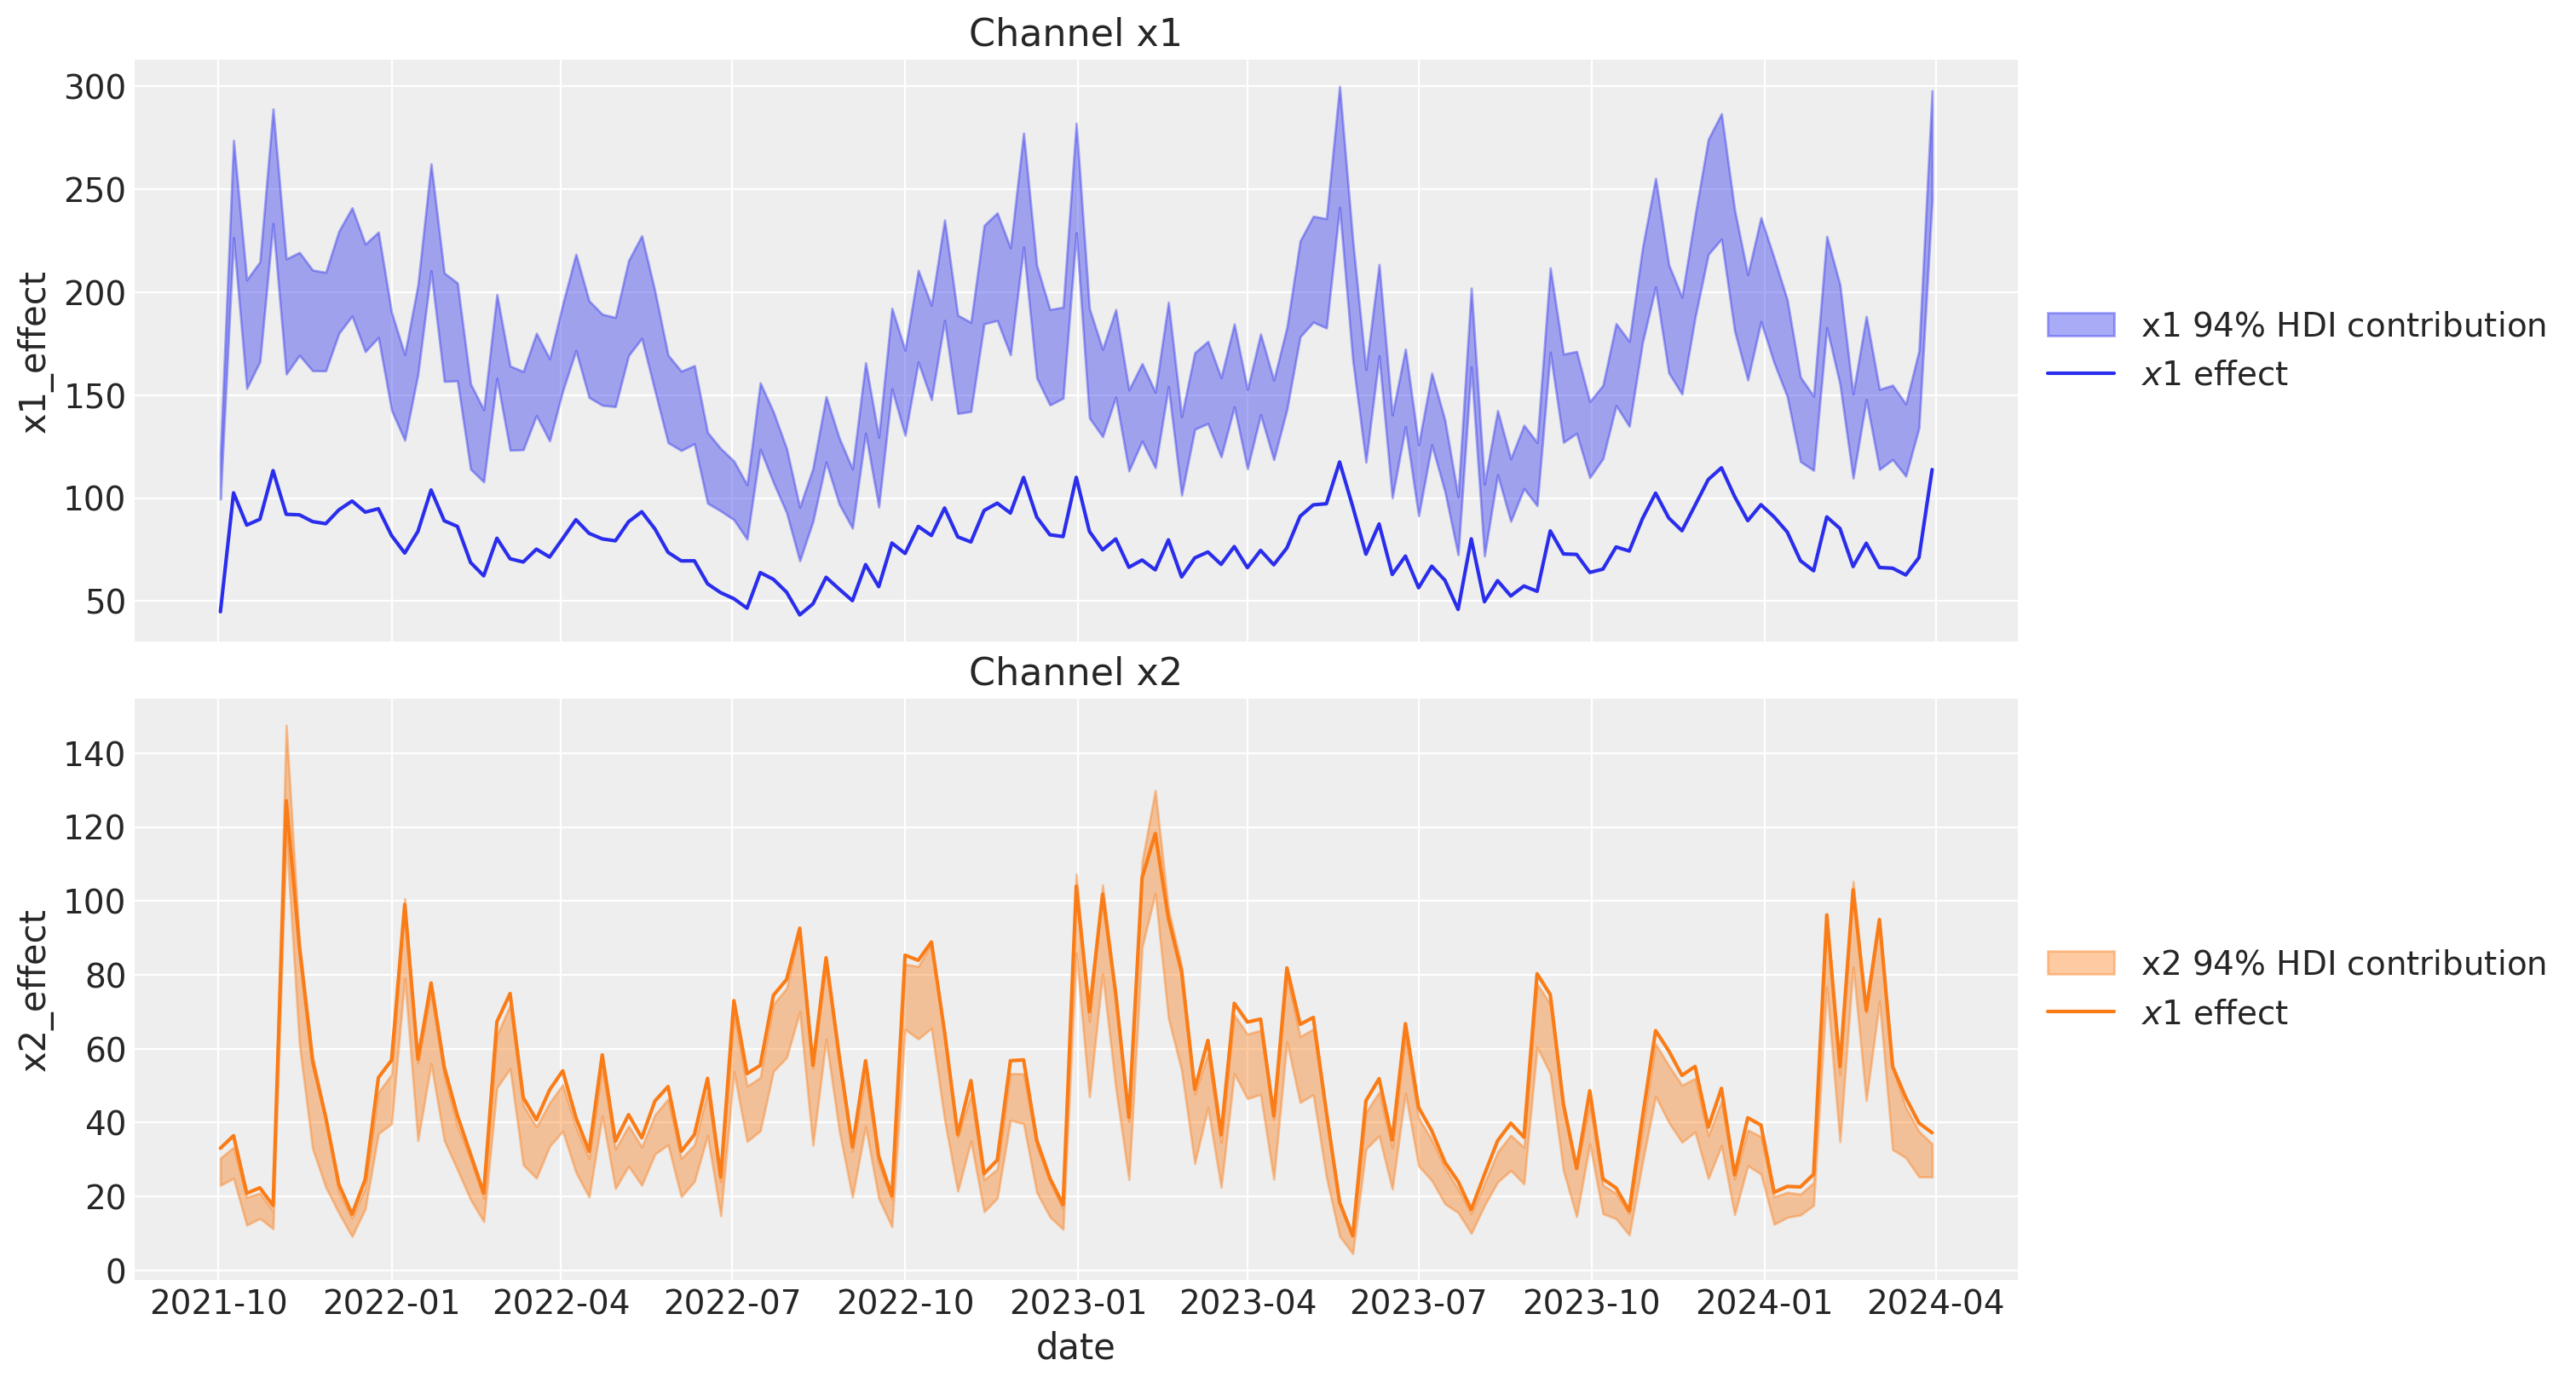

In [11]:
channels_contribution_original_scale = mmm.compute_channel_contribution_original_scale()
channels_contribution_original_scale_hdi = az.hdi(
    ary=channels_contribution_original_scale
)

fig, ax = plt.subplots(
    nrows=2, figsize=(15, 8), ncols=1, sharex=True, sharey=False, layout="constrained"
)

amplitude = 100

for i, x in enumerate(["x1", "x2"]):
    # HDI estimated contribution in the original scale
    ax[i].fill_between(
        x=model_df["date"],
        y1=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 0],
        y2=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 1],
        color=f"C{i}",
        label=rf"{x} $94\%$ HDI contribution",
        alpha=0.4,
    )
    sns.lineplot(
        x="date",
        y=f"{x}_effect",
        data=raw_df.assign(**{f"{x}_effect": lambda df: amplitude * df[f"{x}_effect"]}),  # noqa B023
        color=f"C{i}",
        label=r"$x1$ effect",
        ax=ax[i],
    )

    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set(title=f"Channel {x}")

In [12]:
model_config = {
    "intercept": Prior("Normal", mu=200, sigma=20),
    "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
    "gamma_fourier": Prior("Normal", mu=0, sigma=2, dims="fourier_mode"),
    "intercept_tvp_config": HSGPKwargs(
        m=50, L=None, eta_lam=1.0, ls_mu=5.0, ls_sigma=10.0, cov_func=None
    ),
    "adstock_alpha": Prior("Beta", alpha=2, beta=3, dims="channel"),
    "saturation_lam": Prior("Gamma", alpha=2, beta=2, dims="channel"),
    "saturation_beta": Prior("HalfNormal", sigma=1.5, dims="channel"),
}

mmm_lift = MMM(
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
    date_column="date",
    channel_columns=["x1", "x2"],
    time_varying_intercept=True,
    time_varying_media=False,
    yearly_seasonality=5,
    model_config=model_config,
)

mmm_lift.build_model(X, y)

In [13]:
df_lift_test = pd.DataFrame(
    data={
        "channel": ["x1", "x2", "x1", "x2"],
        "x": [0.25, 0.1, 0.8, 0.25],
        "delta_x": [0.25, 0.1, 0.8, 0.25],
        "delta_y": [90 * 0.25, 175 * 0.1, 90 * 0.8, 175 * 0.25],
        "sigma": [3, 3, 3, 3],
    }
)

df_lift_test

,channel,x,delta_x,delta_y,sigma
0,x1,0.25,0.25,22.50,3
1,x2,0.10,0.10,17.50,3
2,x1,0.80,0.80,72.00,3
3,x2,0.25,0.25,43.75,3


In [14]:
mmm_lift.add_lift_test_measurements(df_lift_test=df_lift_test)

In [15]:
mmm_lift.fit(X, y, **fit_kwargs)
# mmm.sample_posterior_predictive(X, extend_idata=True, combined=True, random_seed=rng)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

In [16]:
# Number of diverging samples
mmm_lift.idata["sample_stats"]["diverging"].sum().item()

0

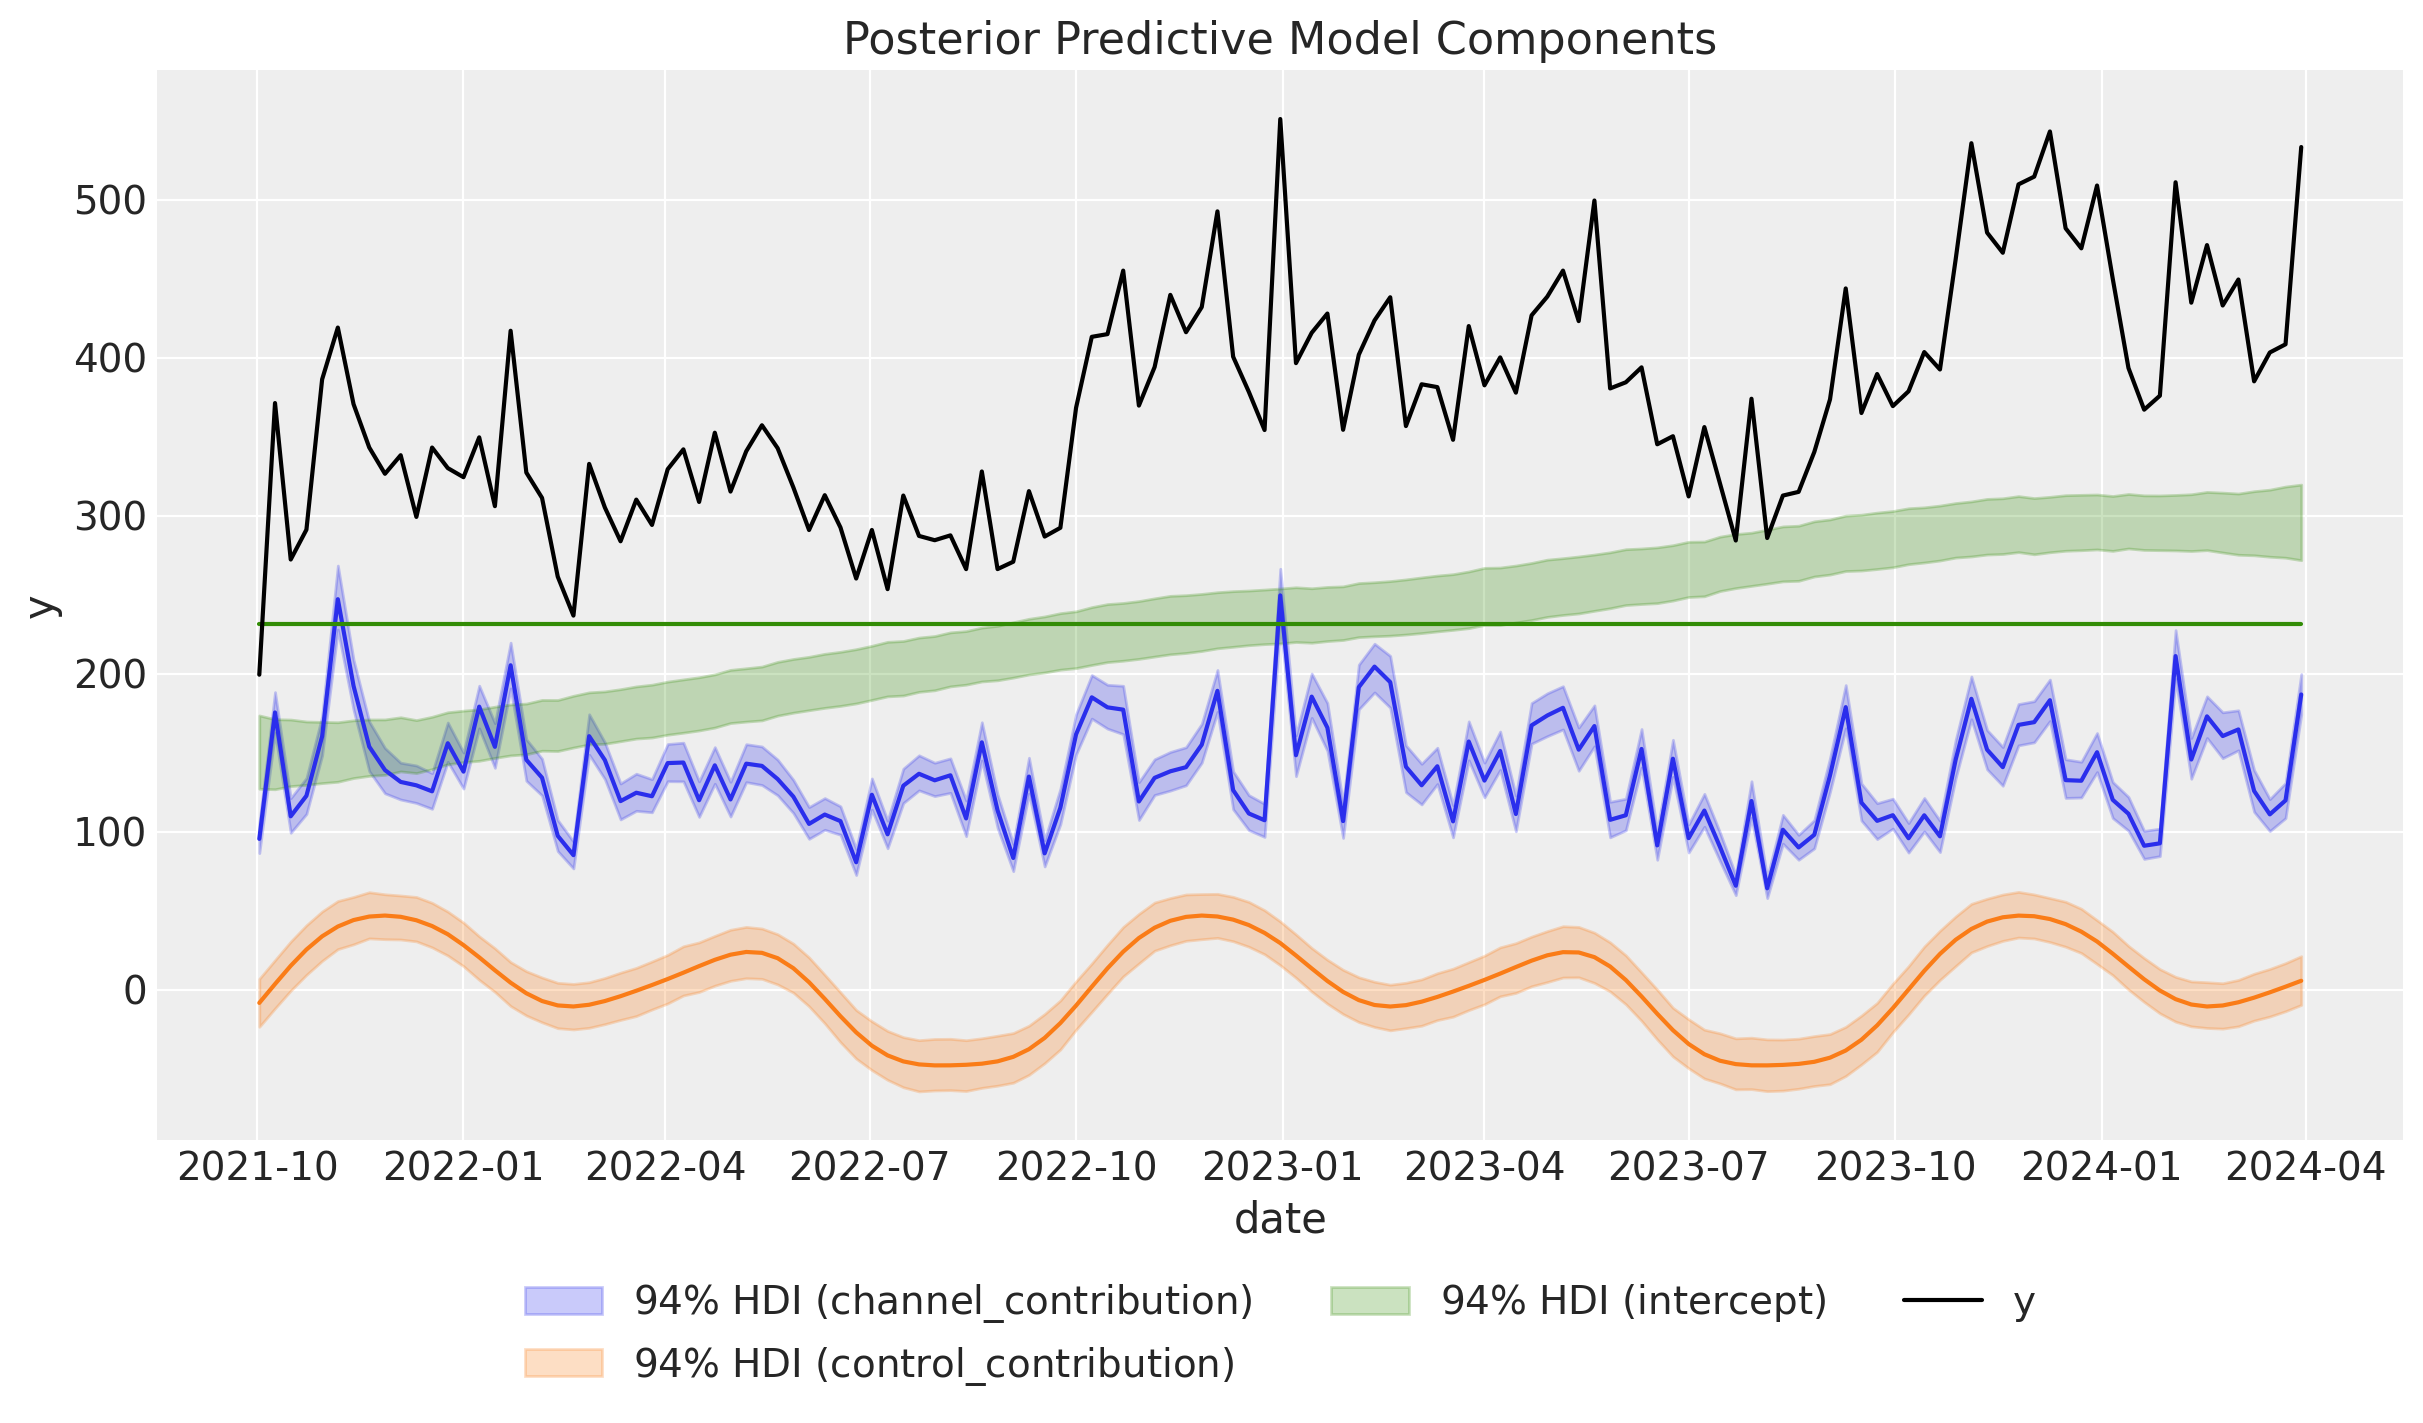

In [17]:
mmm_lift.plot_components_contributions(original_scale=True);

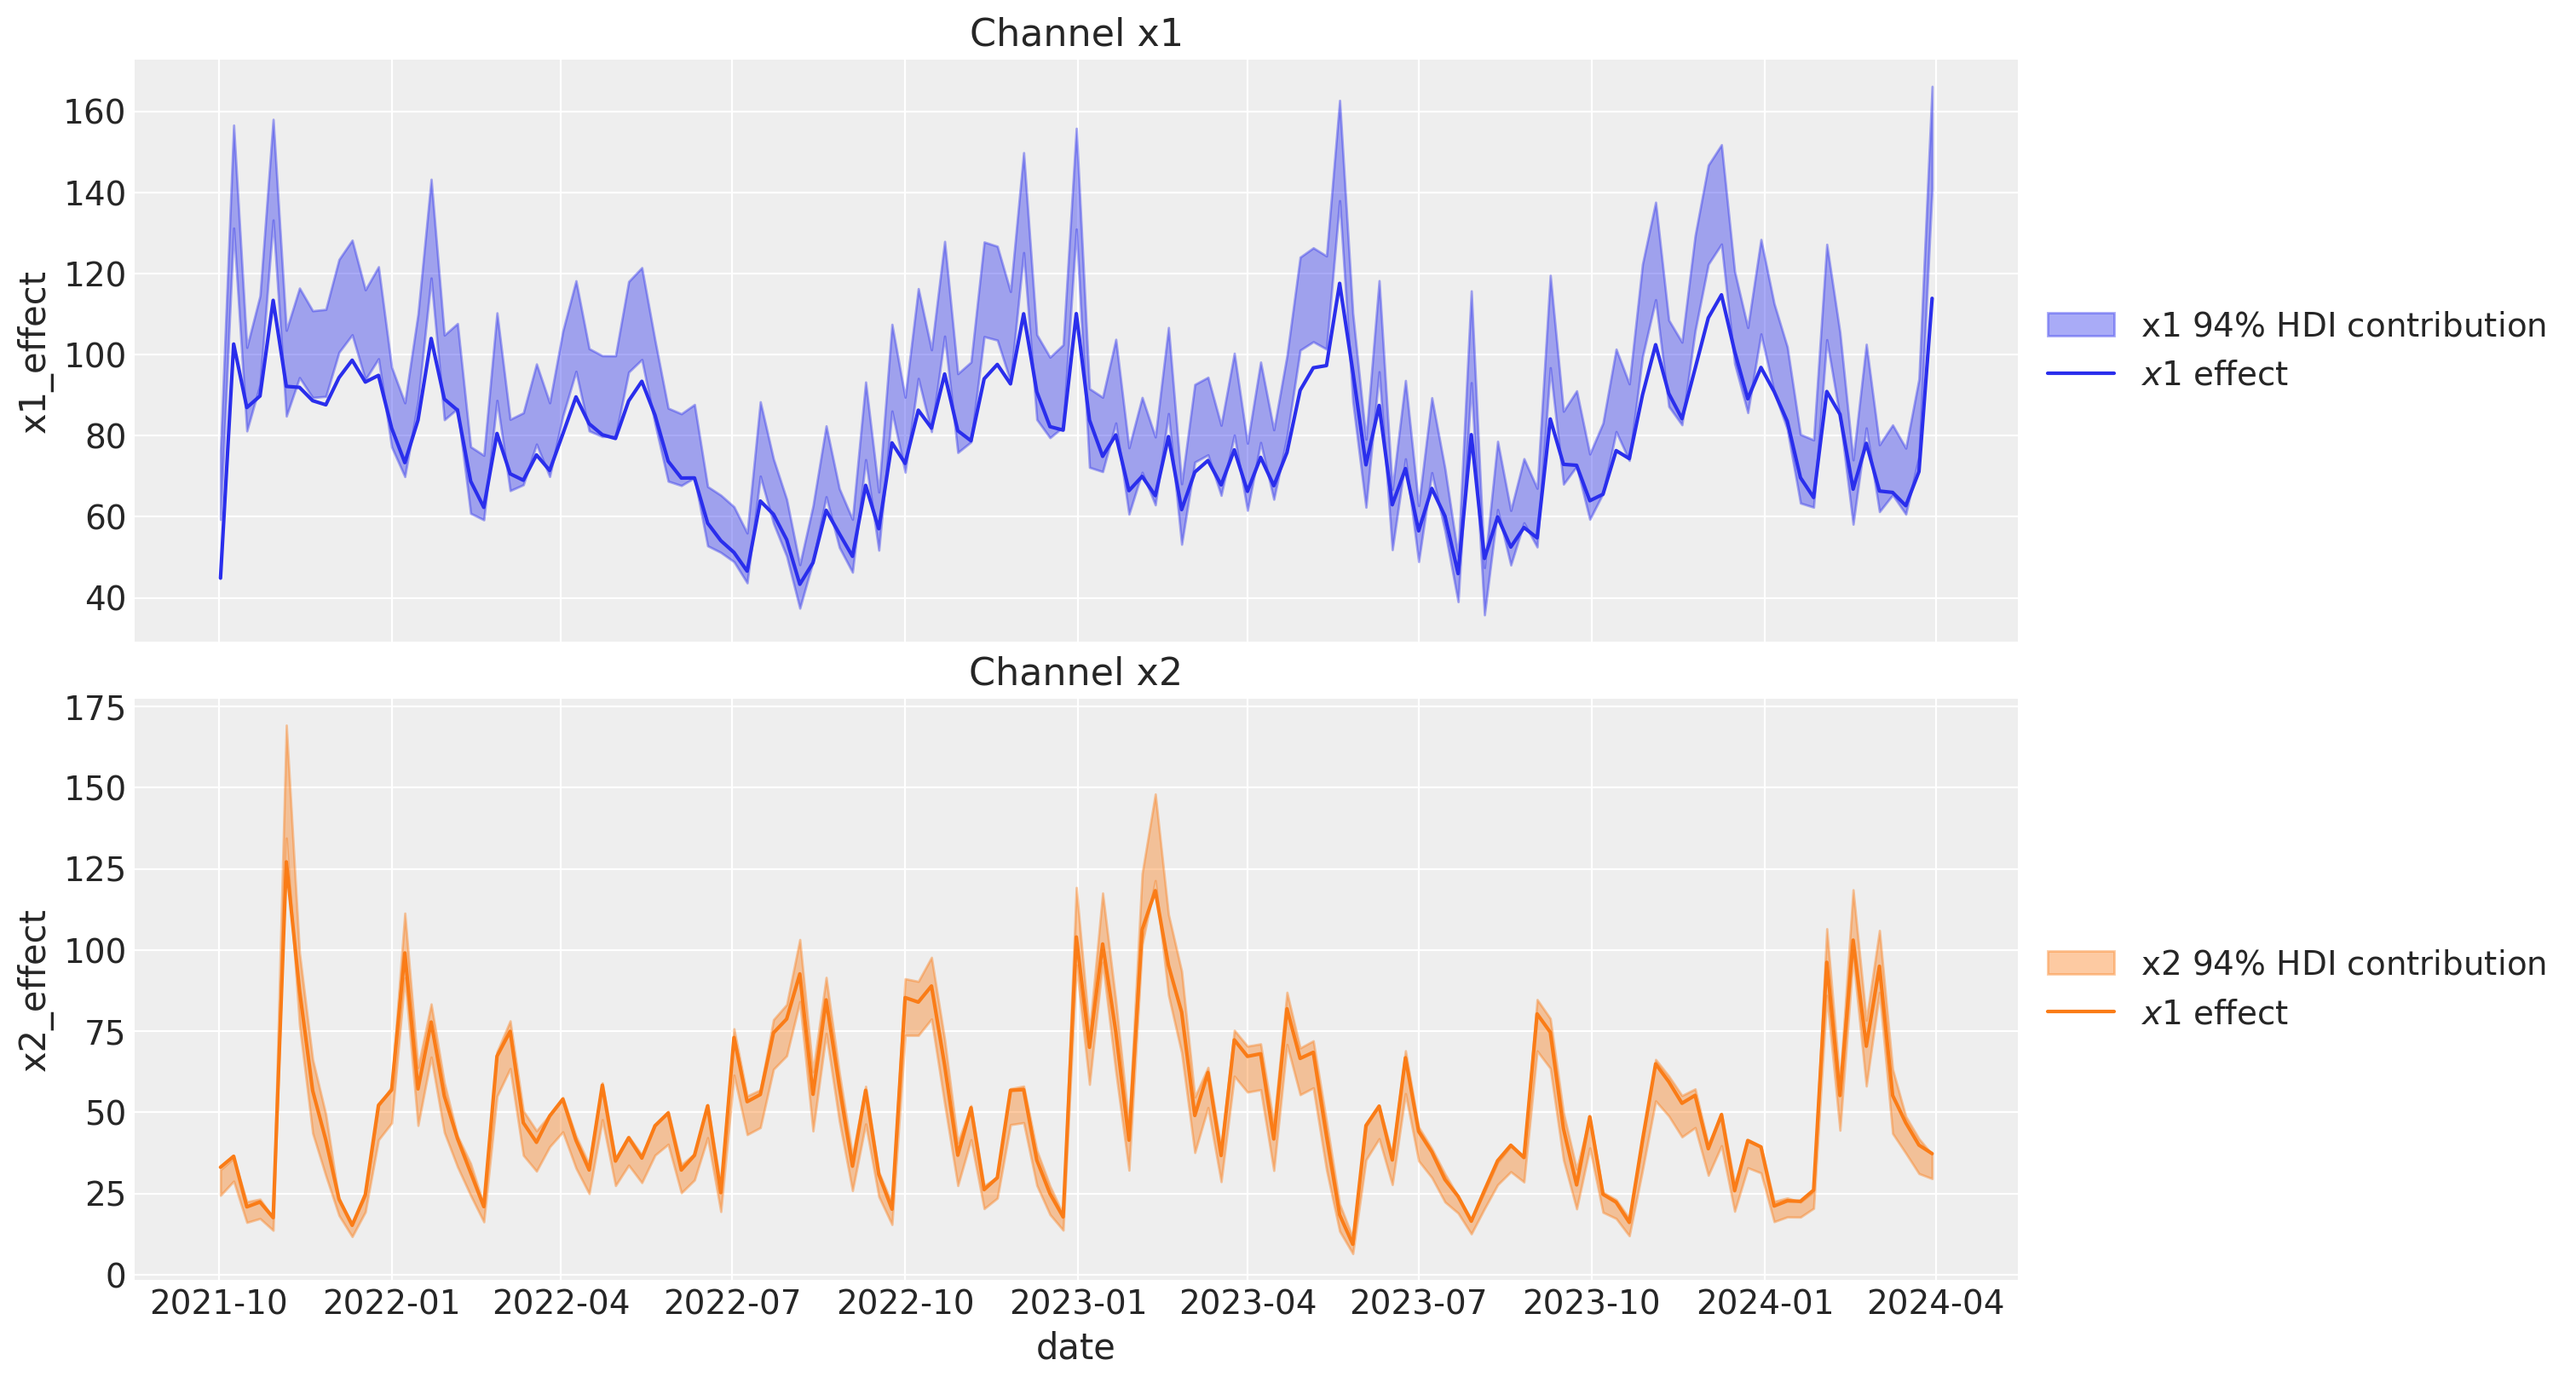

In [18]:
channels_contribution_original_scale = (
    mmm_lift.compute_channel_contribution_original_scale()
)
channels_contribution_original_scale_hdi = az.hdi(
    ary=channels_contribution_original_scale
)

fig, ax = plt.subplots(
    nrows=2, figsize=(15, 8), ncols=1, sharex=True, sharey=False, layout="constrained"
)

amplitude = 100

for i, x in enumerate(["x1", "x2"]):
    # HDI estimated contribution in the original scale
    ax[i].fill_between(
        x=model_df["date"],
        y1=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 0],
        y2=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 1],
        color=f"C{i}",
        label=rf"{x} $94\%$ HDI contribution",
        alpha=0.4,
    )
    sns.lineplot(
        x="date",
        y=f"{x}_effect",
        data=raw_df.assign(**{f"{x}_effect": lambda df: amplitude * df[f"{x}_effect"]}),  # noqa B023
        color=f"C{i}",
        label=r"$x1$ effect",
        ax=ax[i],
    )

    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set(title=f"Channel {x}")